### Initialize the environment

In [1]:
import theano
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
src_dir='../src' # source directory
run_dir_prefix='../MDBN_run/OV_Batch_' # directory with the results of previous runs
data_dir='../data' # directory with the data files

In [6]:
import sys
sys.path.insert(0, src_dir)
import MDBN
import OV

### Load the experiment results

In [35]:
run=1
date_time='2017-01-15_1214' # specify the date and time of the run in the format YYYY-MM-DD_HHMM
run_dir=run_dir_prefix+date_time
runfile='Exp_%s_run_%s.npz' % (date_time, run) # location of the experiment results
config, dbn_dict = MDBN.load_network(runfile, run_dir)

Adding a layer with 799 input and 40 outputs
Adding a layer with 16046 input and 400 outputs
Adding a layer with 400 input and 40 outputs
Adding a layer with 15418 input and 400 outputs
Adding a layer with 400 input and 40 outputs
Adding a layer with 120 input and 24 outputs
Adding a layer with 24 input and 3 outputs


### Visualize the results graphically

In [36]:
datafiles = OV.prepare_OV_TCGA_datafiles(config,data_dir)

In [37]:
dbn_output_list=[]
for key in config['pathways']:
    dbn_output, _ = dbn_dict[key].MLP_output_from_datafile(datafiles[key], datadir=data_dir)
    dbn_output_list.append(dbn_output)

(-0.5, 119.5, 384.5, -0.5)

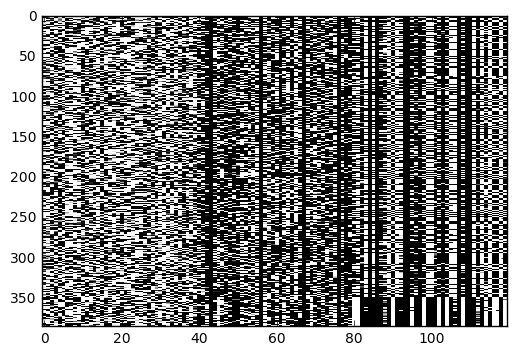

In [38]:
joint_layer = np.concatenate(dbn_output_list,axis=1)
plt.imshow(joint_layer, cmap='gray',interpolation='none')
plt.axis('tight')

([<matplotlib.axis.XTick at 0x1252cd250>,
 <a list of 3 Text xticklabel objects>)

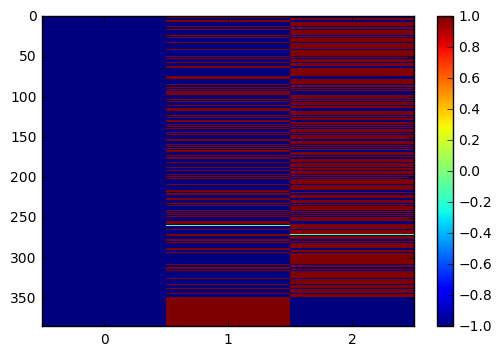

In [39]:
top_output = dbn_dict['top'].get_output(theano.shared(joint_layer,borrow=True))
plt.imshow((top_output>0.8)*np.ones_like(top_output)-(top_output<0.2)*np.ones_like(top_output),interpolation='none',extent=[0,3,385,0])
plt.colorbar()
plt.axis('tight')
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([<matplotlib.axis.XTick at 0x115f8e2d0>,
 <a list of 3 Text xticklabel objects>)

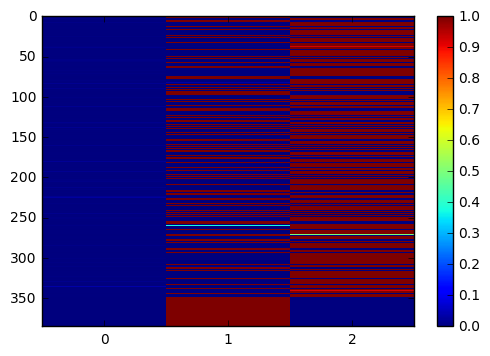

In [40]:
plt.imshow(top_output, interpolation='none',extent=[0,3,385,0])
plt.axis('tight')
plt.colorbar()
plt.xticks(np.arange(0.5,3.5,1),('0','1','2'))

([array([ 385.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 234.,    0.,    0.,    1.,    0.,    0.,    0.,    1.,    0.,  149.]),
  array([ 147.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,  237.])],
 array([  1.87305223e-11,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 3 Lists of Patches objects>)

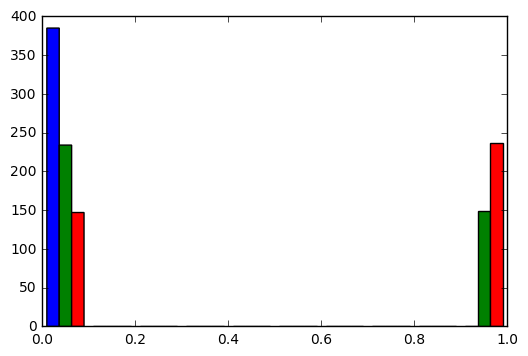

In [41]:
plt.hist(top_output)

In [42]:
code = (top_output[:,0:3] > 0.5) * np.ones_like(top_output[:,0:3])

In [43]:
from utils import find_unique_classes
U = find_unique_classes(code)
cl = U[0]

(array([ 235.,  148.,    2.]),
 array([-0.5,  0.5,  1.5,  2.5]),
 <a list of 3 Patch objects>)

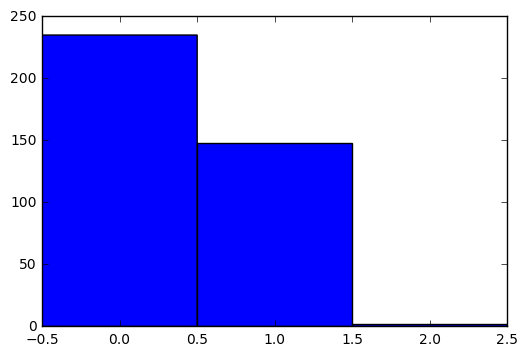

In [44]:
max_cl = np.max(cl)
plt.hist(cl,bins=np.arange(-0.5,max_cl + 1.5,1))

Check Survival curves for the different classes
===============================================

In [45]:
import csv
id=[]
with open('../data/'+datafiles['ME']) as f:
    my_csv = csv.reader(f,delimiter='\t')
    id = my_csv.next()

In [46]:
stat={}
with open('../data/TCGA_Data/data_bcr_clinical_data_patient.csv') as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        patient_id=row[1]
        stat[patient_id]=(row[15],row[16],row[17])

In [47]:
import re
time_list = []
event_list = []
group_list = []
print('The following case IDs were  not found in clinical data')
for index, key in enumerate(id[1:]):
    m = re.match('TCGA-\w+-\d+', key)
    patient_id = m.group(0)
    if patient_id in stat:
        patient_stat = stat[patient_id]
        add_group = True
        try:
            time_list.append(float(patient_stat[2]))
            event_list.append(1)
        except ValueError:
            try:
                time_list.append(float(patient_stat[1]))
                event_list.append(0)
            except ValueError:
                print('No data for %s' % patient_id)
                add_group = False
        if add_group:
            group_list.append(cl[index])
    else:
        print(patient_id)

The following case IDs were  not found in clinical data
TCGA-24-0981
No data for TCGA-04-1519
No data for TCGA-04-1360
TCGA-01-0639
TCGA-01-0642
No data for TCGA-04-1357
TCGA-01-0628
TCGA-04-1331
TCGA-01-0636
TCGA-01-0633
TCGA-01-0637
TCGA-01-0631
TCGA-01-0630


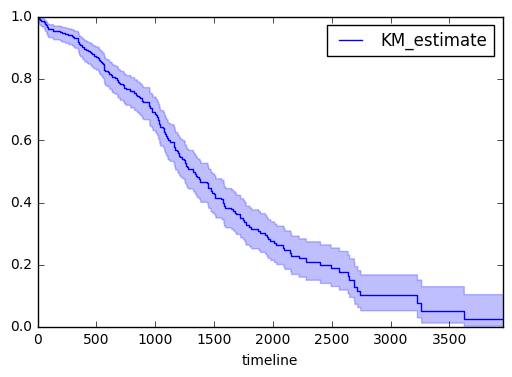

In [48]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(time_list,event_observed=event_list)
kmf.plot()

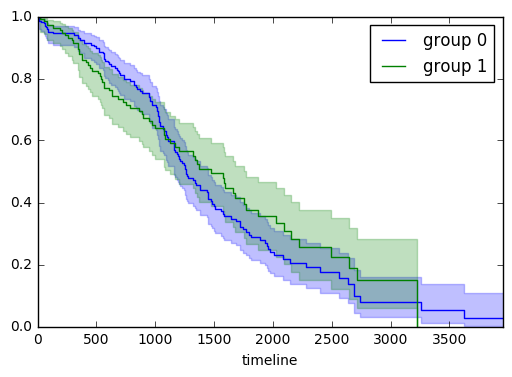

In [49]:
T=np.array(time_list)
E=np.array(event_list)
ix = (np.array(group_list) == 0)
kmf.fit(T[ix], E[ix], label='group 0')
ax=kmf.plot()
for i in range(1,2):
    ix=(np.array(group_list)==i)
    kmf.fit(T[ix], E[ix], label='group %d' % i)
    kmf.plot(ax=ax)

In [50]:
npz=np.load(run_dir+'/'+runfile)

In [51]:
classes=npz['classes']

In [52]:
classes

array([[  2.83016823e-03,   2.19919291e-10,   1.00000000e+00],
       [  3.41402701e-05,   1.00000000e+00,   3.48485560e-06],
       [  9.68886167e-03,   1.87305223e-11,   1.00000000e+00],
       ..., 
       [  2.01899078e-04,   1.00000000e+00,   1.04985375e-07],
       [  6.92420639e-04,   1.00000000e+00,   8.50692246e-08],
       [  9.23326996e-04,   1.00000000e+00,   1.19811853e-06]], dtype=float32)

([array([ 385.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]),
  array([ 234.,    0.,    0.,    1.,    0.,    0.,    0.,    1.,    0.,  149.]),
  array([ 147.,    0.,    0.,    0.,    1.,    0.,    0.,    0.,    0.,  237.])],
 array([  1.87305223e-11,   1.00000000e-01,   2.00000000e-01,
          3.00000000e-01,   4.00000000e-01,   5.00000000e-01,
          6.00000000e-01,   7.00000000e-01,   8.00000000e-01,
          9.00000000e-01,   1.00000000e+00]),
 <a list of 3 Lists of Patches objects>)

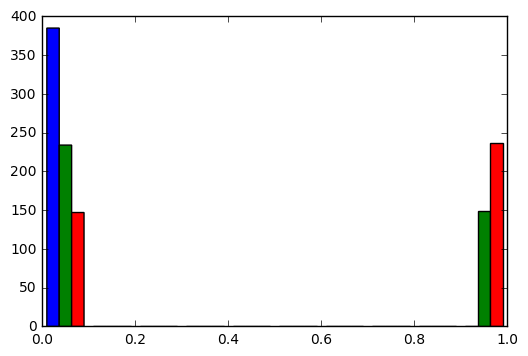

In [53]:
plt.hist(classes)